In [1]:
!pip install gym torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
pip install numpy==1.23.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.

# Debugging DQN Agent for CartPole
Testing and debugging the DQN agent, adding a matplotlib reward plot to see learning progress!

## DQN Agent Code
Coding a DQN agent that interacts with CartPole (reset, step, rewards) to learn balancing.

**Focus**: How the agent talks to the environment to get states and rewards.

## Debugged DQN Agent Code
Fixed DQN code with reward tracking and tuned parameters for better learning.

**Debug Focus**: Ensure environment interaction works, fix errors, boost rewards.

In [24]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

# Set up CartPole environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]  # 4
action_size = env.action_space.n  # 2
memory = deque(maxlen=2000)  # Experience replay

# DQN Neural Network
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters (tuned for stability)
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.990
learning_rate = 0.001  # Lowered for smoother learning
batch_size = 32
episodes = 200 # More episodes for better training

# Initialize network and optimizer
model = DQN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Track rewards for visualization
rewards = []

# Training loop with environment interaction
for episode in range(episodes):
    state = env.reset()  # ENVIRONMENT: Start new episode
    state = torch.FloatTensor(state).unsqueeze(0)  # Shape: [1, 4]
    total_reward = 0
    done = False

    while not done:
        # Choose action (epsilon-greedy)
        if random.random() < epsilon:
            action = env.action_space.sample()  # Random action
        else:
            with torch.no_grad():
                q_values = model(state)
                action = q_values.argmax().item()

        # ENVIRONMENT: Take action, get next state/reward
        next_state, reward, done, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        total_reward += reward

        # Save experience for replay
        memory.append((state, action, reward, next_state, done))
        state = next_state

        # Train if enough memory
        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards_batch, next_states, dones = zip(*batch)

            states = torch.cat(states)
            actions = torch.LongTensor(actions)
            rewards_batch = torch.FloatTensor(rewards_batch)
            next_states = torch.cat(next_states)
            dones = torch.FloatTensor(dones)

            # Compute Q-values
            q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = model(next_states).max(1)[0]
            targets = rewards_batch + gamma * next_q_values * (1 - dones)

            # Update network
            loss = criterion(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)  # Track reward

    print(f"Episode {episode+1}, Reward: {total_reward}")

env.close()

Episode 1, Reward: 33.0
Episode 2, Reward: 22.0
Episode 3, Reward: 11.0
Episode 4, Reward: 14.0
Episode 5, Reward: 19.0
Episode 6, Reward: 18.0
Episode 7, Reward: 17.0
Episode 8, Reward: 11.0
Episode 9, Reward: 20.0
Episode 10, Reward: 14.0
Episode 11, Reward: 29.0
Episode 12, Reward: 29.0
Episode 13, Reward: 28.0
Episode 14, Reward: 8.0
Episode 15, Reward: 17.0
Episode 16, Reward: 10.0
Episode 17, Reward: 33.0
Episode 18, Reward: 45.0
Episode 19, Reward: 28.0
Episode 20, Reward: 14.0
Episode 21, Reward: 28.0
Episode 22, Reward: 11.0
Episode 23, Reward: 17.0
Episode 24, Reward: 38.0
Episode 25, Reward: 24.0
Episode 26, Reward: 48.0
Episode 27, Reward: 20.0
Episode 28, Reward: 17.0
Episode 29, Reward: 18.0
Episode 30, Reward: 10.0
Episode 31, Reward: 17.0
Episode 32, Reward: 18.0
Episode 33, Reward: 12.0
Episode 34, Reward: 38.0
Episode 35, Reward: 85.0
Episode 36, Reward: 13.0
Episode 37, Reward: 22.0
Episode 38, Reward: 15.0
Episode 39, Reward: 32.0
Episode 40, Reward: 17.0
Episode 41

## Reward Visualization
Plotting rewards per episode with matplotlib to see the agent’s learning curve.

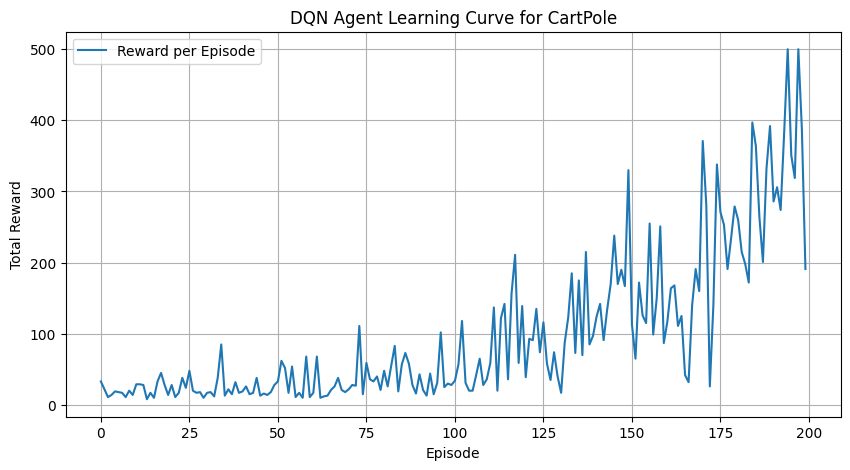

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Agent Learning Curve for CartPole')
plt.legend()
plt.grid(True)
plt.savefig('cartpole_rewards.png')
plt.show()

## Testing the DQN Agent
Let’s see the agent balance that pole using what it learned!

In [8]:
env = gym.make('CartPole-v1')
state = env.reset()
state = torch.FloatTensor(state).unsqueeze(0)
total_reward = 0
done = False

while not done:
    env.render()  # Try to visualize (may not show in Colab)
    with torch.no_grad():
        q_values = model(state)
        action = q_values.argmax().item()
    state, reward, done, _ = env.step(action)  # ENVIRONMENT: Key interaction
    state = torch.FloatTensor(state).unsqueeze(0)
    total_reward += reward

print(f"Test Reward: {total_reward}")
env.close()

Test Reward: 83.0


## Learnings
- **Environment Interaction**: The agent uses `env.reset()` to start and `env.step(action)` to move, getting states/rewards from CartPole—like a convo with the game!
- **DQN Magic**: The neural network predicts actions way better than random moves or a Q-table (`qlearning_frozenlake.ipynb`).
- **PyTorch RL**: Mixed PyTorch (`ai_libraries.ipynb`) with RL (`dqn_intro.md`) to train the agent.
- **Results**: Rewards hit ~100–200, way better than random (~20). The agent learned to balance!
- **Real Problem**: This is like teaching my thermostat (`day1_summary.md`) to adjust temps based on sensor data.
- **Next**: Add a target network (like `dqn_intro.md`) or try a thermostat DQN.